In [153]:
import os
import glob
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

%matplotlib inline
import matplotlib.pyplot as plt

np.random.seed(42)

In [154]:
import tensorflow as tf
tf.random.set_seed(42)

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import LocallyConnected1D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import UpSampling1D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.models import clone_model

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from keras.utils import plot_model

In [155]:
timesteps = 300 #1440
input_dim = 1
n_epochs = 100
batch_size = 32
drop_rate = 0.8
n_samples = 6000

In [156]:
# load real-world time series trading data
def load_data(symbol):
    
    ROOT = os.path.join(r'C:\Users\vhuang\Desktop\Hazelnut', 'datasets')
    allfiles = glob.glob(os.path.join(ROOT, symbol, '*.csv'))
    n_samples = np.size(allfiles)
    
    data = np.zeros((n_samples, timesteps, input_dim))
    for i, file in enumerate(allfiles):
        df = pd.read_csv(file, usecols=[4])
        data[i] = df.values[510:810] # only use the day sessioin data
    
    return data

In [157]:
symbol_list = ['kiwi']
# symbol_list = ['apple', 'banana', 'cherry', 'grape', 'kiwi', 'orange']
data_dict = {}

for symbol in symbol_list:
    data_dict[symbol] = load_data(symbol)

In [158]:
def train_test_split(data):
    # training set is 0.8 of the total
    test_split = int(data.shape[0]*0.8)
    X_train_full = data[:test_split]
    X_test = data[test_split:]
    # validation set is 0.1 of the training
    valid_split = int(test_split*0.9)
    X_train = X_train_full[:valid_split]
    X_valid = X_train_full[valid_split:]
    
    return X_train, X_test, X_valid

In [159]:
RawData = data_dict['kiwi'].copy()

X_train, X_test, X_valid = train_test_split(RawData)

In [160]:
def preprocess(data):
    for i in range(data.shape[0]):
        scaler = StandardScaler()
        data[i] = scaler.fit_transform(data[i])
        
    return data

In [161]:
X_train = preprocess(X_train)
X_test = preprocess(X_test)
X_valid = preprocess(X_valid)

In [162]:
print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)

(3866, 300, 1)
(1075, 300, 1)
(430, 300, 1)


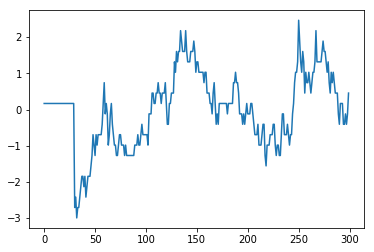

In [163]:
plt.plot(X_train[100])

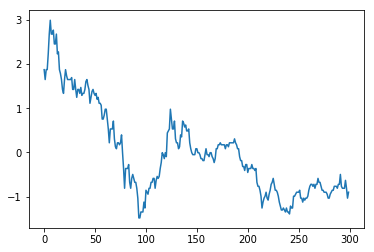

In [164]:
plt.plot(X_train[3000])

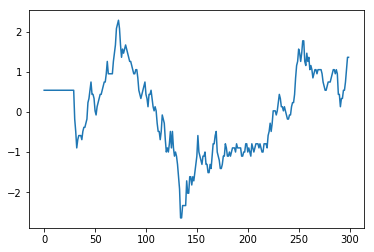

In [165]:
plt.plot(X_train[573])

In [166]:
# Convolutional Autoencoder
# with more Conv1D layers

$$new\ width(height) = \frac{width(height) - F + 2 \times P}{S} + 1$$

In [182]:
# input sequence
input_seq = Input(shape=(timesteps, input_dim))

# encoder with Conv1D and MaxPooling1D
X = Conv1D(filters=4, kernel_size=3, strides=1, padding='causal', activation='relu')(input_seq)
X = BatchNormalization()(X)
X = MaxPooling1D(4, padding='valid')(X)

X = Conv1D(filters=8, kernel_size=3, strides=1, padding='causal', activation='relu')(X)
X = BatchNormalization()(X)
X = Conv1D(filters=8, kernel_size=3, strides=1, padding='causal', activation='relu')(X)
X = BatchNormalization()(X)
X = MaxPooling1D(5, padding='valid')(X)

X = Conv1D(filters=10, kernel_size=3, strides=1, padding='causal', activation='relu')(X)
X = BatchNormalization()(X)
X = Conv1D(filters=10, kernel_size=3, strides=1, padding='causal', activation='relu')(X)
X = BatchNormalization()(X)
encoded = MaxPooling1D(5, padding='valid')(X)

In [183]:
# decoder with Conv1D and UpSampling1D
X = Conv1D(filters=10, kernel_size=3, strides=1, padding='causal', activation='relu')(encoded)
X = BatchNormalization()(X)
X = Conv1D(filters=10, kernel_size=3, strides=1, padding='causal', activation='relu')(X)
X = BatchNormalization()(X)
X = UpSampling1D(5)(X)

X = Conv1D(filters=8, kernel_size=3, strides=1, padding='causal', activation='relu')(X)
X = BatchNormalization()(X)
X = Conv1D(filters=8, kernel_size=3, strides=1, padding='causal', activation='relu')(X)
X = BatchNormalization()(X)
X = UpSampling1D(5)(X)

X = Conv1D(filters=4, kernel_size=3, strides=1, padding='causal', activation='relu')(X)
X = BatchNormalization()(X)
X = UpSampling1D(4)(X)
decoded = Conv1D(filters=1, kernel_size=3, strides=1, padding='causal', activation='sigmoid')(X)

In [184]:
Conv1DAuto_Real = Model(inputs=[input_seq], outputs=[decoded])

In [185]:
Conv1DAuto_Real.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 300, 1)]          0         
_________________________________________________________________
conv1d_99 (Conv1D)           (None, 300, 4)            16        
_________________________________________________________________
batch_normalization_v2_90 (B (None, 300, 4)            16        
_________________________________________________________________
max_pooling1d_27 (MaxPooling (None, 75, 4)             0         
_________________________________________________________________
conv1d_100 (Conv1D)          (None, 75, 8)             104       
_________________________________________________________________
batch_normalization_v2_91 (B (None, 75, 8)             32        
_________________________________________________________________
conv1d_101 (Conv1D)          (None, 75, 8)             200

In [186]:
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999,
                                  epsilon=None, decay=0.0, amsgrad=False)

checkpoint_cb = ModelCheckpoint('Conv1DAuto_Real_daySession.h5', save_best_only=True)

earlystopping_cb = EarlyStopping(patience=5)

In [187]:
Conv1DAuto_Real.compile(loss='mse', optimizer=optimizer,
                     metrics=['mse'])

In [188]:
history_real = Conv1DAuto_Real.fit(X_train, X_train, batch_size=batch_size, epochs=n_epochs,
                        callbacks=[checkpoint_cb, earlystopping_cb], 
                        validation_data=(X_valid, X_valid))

Train on 3866 samples, validate on 430 samples
Epoch 1/100
3866/3866 [==============================] - 6s 2ms/sample - loss: 1.0622 - mse: 1.0622 - val_loss: 0.8953 - val_mse: 0.8953
Epoch 2/100
3866/3866 [==============================] - 4s 1ms/sample - loss: 0.8227 - mse: 0.8227 - val_loss: 0.6841 - val_mse: 0.6841
Epoch 3/100
3866/3866 [==============================] - 4s 1ms/sample - loss: 0.7549 - mse: 0.7549 - val_loss: 0.6398 - val_mse: 0.6398 loss: 0.7599
Epoch 4/100
3866/3866 [==============================] - 4s 1ms/sample - loss: 0.7201 - mse: 0.7201 - val_loss: 0.6163 - val_mse: 0.6163
Epoch 5/100
3866/3866 [==============================] - 4s 1ms/sample - loss: 0.6989 - mse: 0.6989 - val_loss: 0.6000 - val_mse: 0.6000
Epoch 6/100
3866/3866 [==============================] - 4s 1ms/sample - loss: 0.6883 - mse: 0.6883 - val_loss: 0.5951 - val_mse: 0.5951
Epoch 7/100
3866/3866 [==============================] - 4s 1ms/sample - loss: 0.6820 - mse: 0.6820 - val_loss: 0.5922

3866/3866 [==============================] - 4s 1ms/sample - loss: 0.6323 - mse: 0.6323 - val_loss: 0.5506 - val_mse: 0.5506
Epoch 60/100
3866/3866 [==============================] - 4s 991us/sample - loss: 0.6325 - mse: 0.6325 - val_loss: 0.5513 - val_mse: 0.5513
Epoch 61/100
3866/3866 [==============================] - 4s 1ms/sample - loss: 0.6319 - mse: 0.6319 - val_loss: 0.5495 - val_mse: 0.5495
Epoch 62/100
3866/3866 [==============================] - 4s 991us/sample - loss: 0.6317 - mse: 0.6317 - val_loss: 0.5500 - val_mse: 0.5500
Epoch 63/100
3866/3866 [==============================] - 4s 1ms/sample - loss: 0.6313 - mse: 0.6313 - val_loss: 0.5492 - val_mse: 0.5492
Epoch 64/100
3866/3866 [==============================] - 4s 986us/sample - loss: 0.6311 - mse: 0.6311 - val_loss: 0.5492 - val_mse: 0.5492
Epoch 65/100
3866/3866 [==============================] - 4s 999us/sample - loss: 0.6311 - mse: 0.6311 - val_loss: 0.5506 - val_mse: 0.5506
Epoch 66/100
3866/3866 [===============

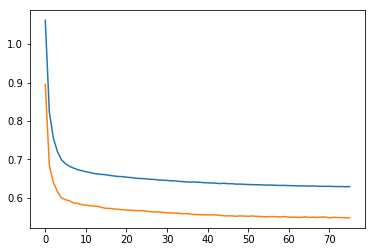

In [189]:
plt.plot(history_real.history['loss'])
plt.plot(history_real.history['val_loss'])

In [190]:
X_pred = Conv1DAuto_Real.predict(X_test)

C:\Users\vhuang\Anaconda3\envs\py36tf2\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


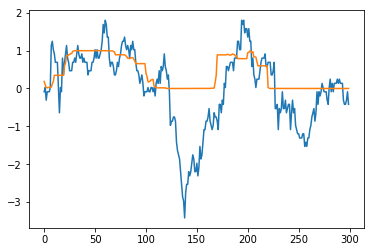

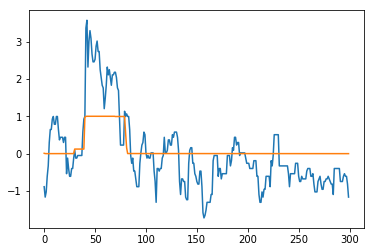

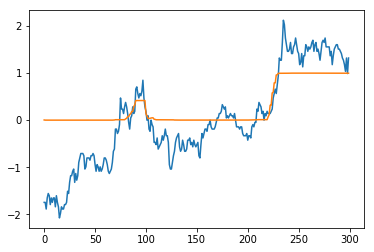

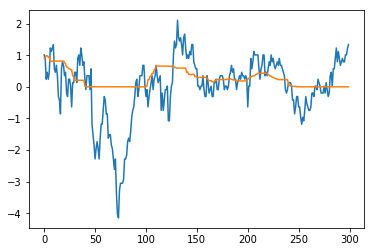

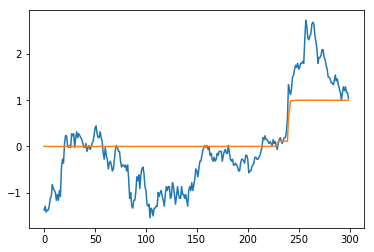

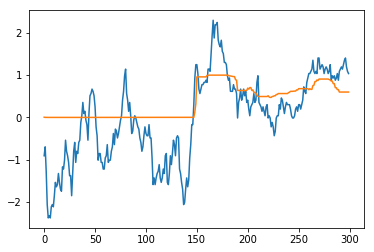

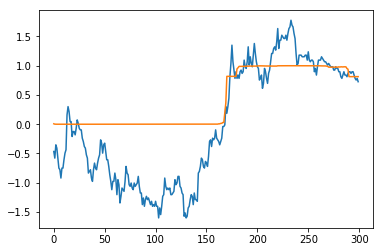

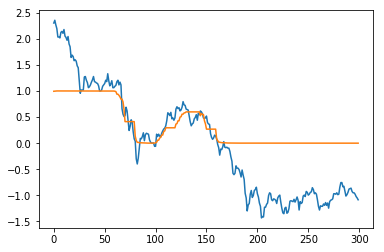

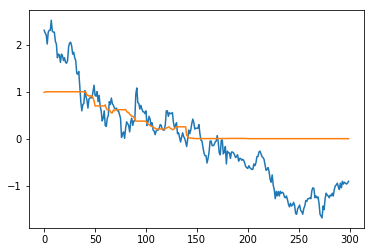

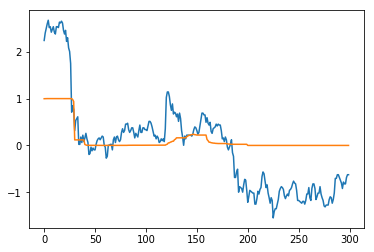

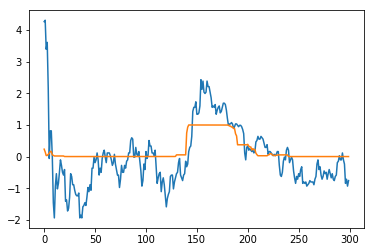

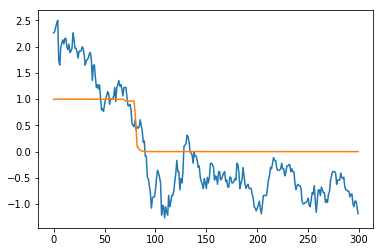

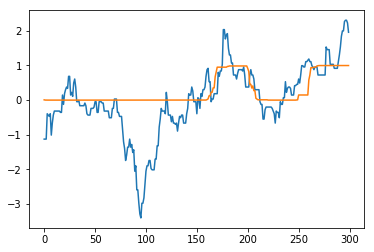

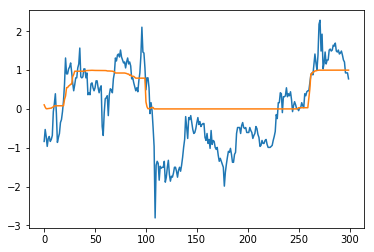

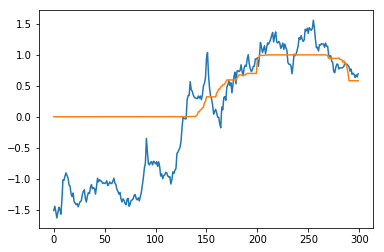

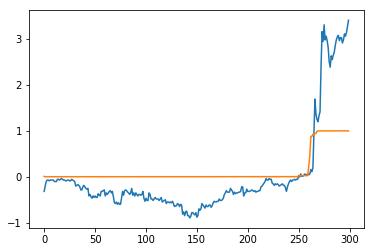

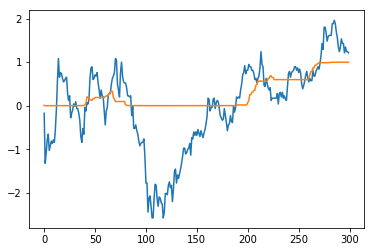

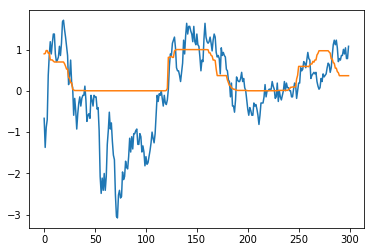

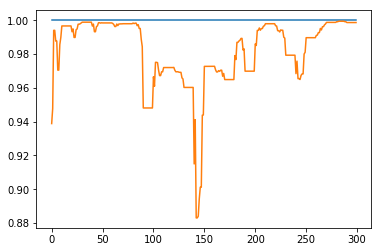

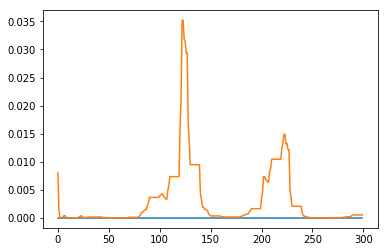

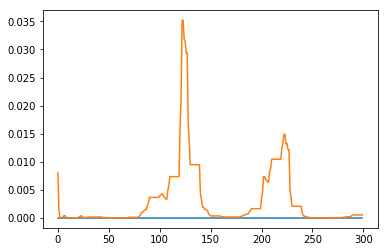

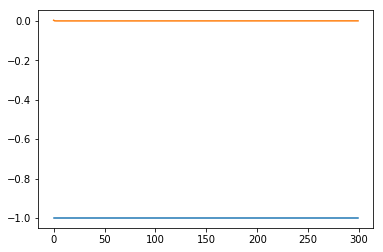

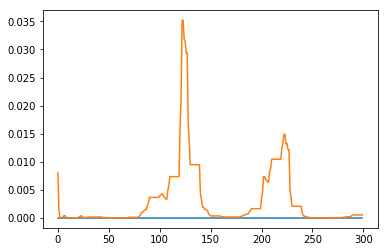

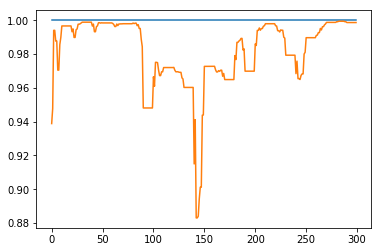

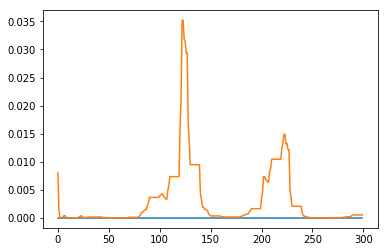

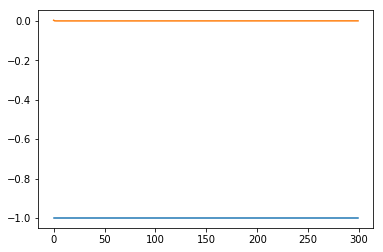

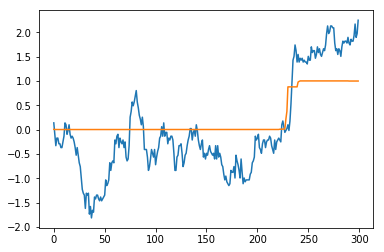

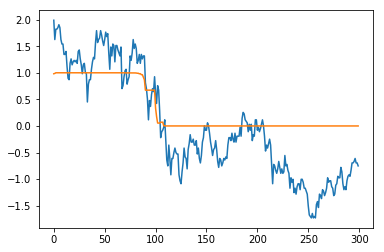

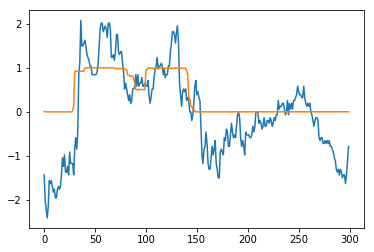

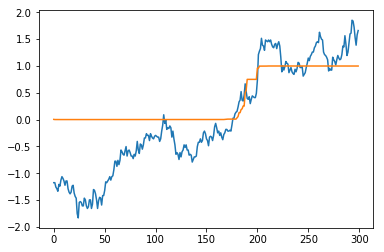

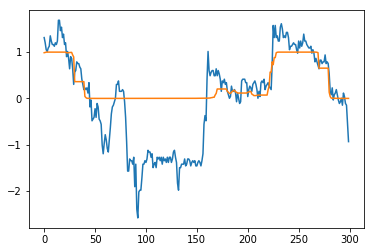

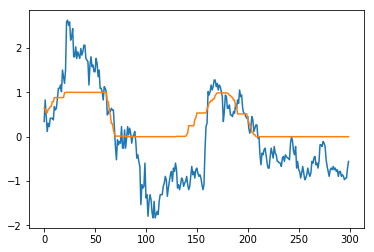

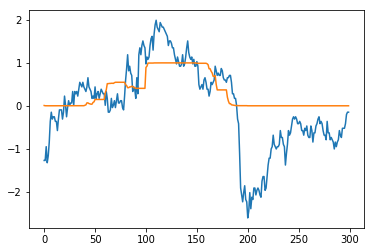

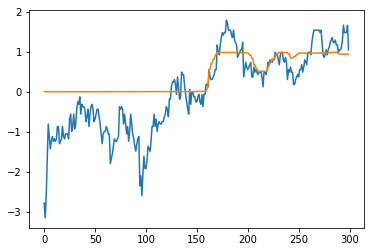

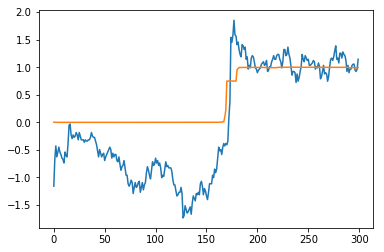

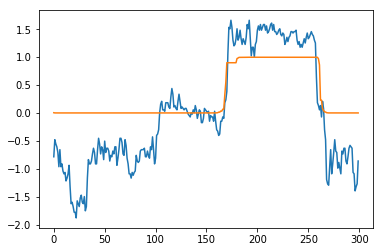

In [191]:
for i in range(len(X_pred)):
    if i % 30 == 0:
        plt.figure(figsize=(6,4))
        plt.plot(X_test[i])
        plt.plot(X_pred[i])